In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from functools import partial
import shap
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

from biobank_olink.constants import PROJECT_DATA

nb_data = PROJECT_DATA / "olink"
olink_xlsx = nb_data / "Olink_whole_caucasian_nonrandom_Zscore.parquet"

sns.set_theme()
pl.__version__

'1.7.1'

In [2]:
import polars.selectors as cs

feat2code = {
    "SBP": "4080",
    "DBP": "4079",
    "ASI": "21021",
    "DATE": "53",
}
instances = [0, 1, 2, 3]

df_followups = (
    pl.scan_csv(nb_data / "BP_ASI_instances0123_participant.csv")
    .select(
        "eid",
        *[
            pl.concat_list(cs.contains(f"{feat2code[feat]}-{ins}.")).list.mean().alias(
                f"{feat}/{ins}")
            for feat in ["SBP", "DBP"]
            for ins in instances
        ],
        *[
            pl.col(f"{feat2code[feat]}-{ins}.0").cast(t).alias(f"{feat}/{ins}")
            for feat, t in [("ASI", pl.Float64), ("DATE", pl.Date)]
            for ins in instances
        ],
    )
    .with_columns(
        (pl.col("^DATE/[123]$") - pl.col("DATE/0")).dt.total_days() / 365.25
    )
    .drop("DATE/0")
    .unpivot(index="eid")
    .filter(pl.col("value").is_not_null())
    .with_columns(
        pl.col("variable").str.split_exact("/", 1)
    )
    .with_columns(
        variable=pl.col("variable").struct[0],
        ins_index=pl.col("variable").struct[1].cast(pl.Int64)
    )
    .collect()
    .pivot(index=["eid", "ins_index"], on="variable")
    .rename({"DATE": "followup_time"})
)
df_followups

eid,ins_index,SBP,DBP,ASI,followup_time
i64,i64,f64,f64,f64,f64
3638897,0,165.5,83.0,null,null
4415148,0,155.5,96.5,null,null
5164480,0,152.0,97.5,10.5921,null
3753362,0,126.0,79.5,null,null
1689649,0,100.0,65.0,null,null
…,…,…,…,…,…
1627458,3,null,null,null,15.115674
1040988,3,null,null,null,12.227242
5950006,3,null,null,null,14.89117


In [3]:
def create_target_at_followups(target) -> pl.DataFrame:
    df_baseline = (
        df_followups
        .filter(pl.col("ins_index") == 0)
        .rename({target: "target_at_baseline"})
        .select("eid", "target_at_baseline")
    )
    return (
        df_followups
        .filter(
            pl.col("ins_index") != 0,
            pl.col(target).is_not_null(),
        )
        .select("eid", target, "followup_time")
        .join(df_baseline, on="eid")
        .select(
            "eid",
            "followup_time",
            target=(pl.col(target) - pl.col("target_at_baseline")) / pl.col("followup_time")
        )
    )

In [4]:
index_cols = ["eid", "sex", "age", "BMI", "Smokinstatus"]
cols = ["protein_id", "result"] + index_cols

coding = (
    pl.read_csv(nb_data / "coding143.tsv", separator="\t")
    .with_columns(pl.col("meaning").str.split(";").list.get(0))
)
df_ol = (
    pl.scan_parquet(olink_xlsx.with_suffix(".parquet"))
    .filter(
        pl.col("SBP").is_not_null(),
        pl.col("DBP").is_not_null(),
        pl.col("HTNgroup").is_in([0, 1])
    )
    .select(cols)
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
    .collect()
    .pivot(on="protein_id", index=index_cols, values="result",
           aggregate_function="first")
)

df_ol = (
    df_ol.with_columns(
        df_ol["Smokinstatus"].to_dummies(drop_first=True)
    )
    .drop("Smokinstatus")
)
df_ol

eid,sex,age,BMI,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,ACE,ACE2,ACHE,ACOT13,ACOX1,ACP1,ACP5,ACP6,ACRBP,ACRV1,ACSL1,ACTA2,ACTN2,ACTN4,ACVRL1,ACY1,ACY3,ACYP1,ADA,ADA2,ADAM12,…,WFDC12,WFDC2,WFIKKN1,WFIKKN2,WIF1,WNT9A,WWP2,XCL1,XG,XIAP,XPNPEP2,XRCC4,YAP1,YARS1,YES1,YJU2,YOD1,YTHDF3,YWHAQ,YY1,ZBP1,ZBTB16,ZBTB17,ZCCHC8,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,Smokinstatus_0,Smokinstatus_2,Smokinstatus_null
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8
1000366,1,66,23.7966,0.0638,0.08315,-0.4971,-0.09945,0.1375,-0.3963,1.9904,-0.0676,-0.5911,0.0,0.75245,-0.0005,0.10285,0.42995,0.0527,0.6581,0.0942,-0.01105,0.1137,-0.8745,0.1729,1.69895,0.0577,0.3387,0.0539,0.00375,-0.1569,-0.3481,0.5234,0.0256,0.1715,-0.181,-0.3345,…,0.4894,null,0.10655,0.2221,-0.08805,-0.1691,0.1383,-0.5023,-0.6498,0.0922,-1.3403,0.04305,-0.1551,0.5775,-0.5473,-0.2542,-0.178,0.09665,-0.0655,0.1137,0.10025,-0.00145,-0.1213,0.1454,0.5795,-0.4043,-0.2223,-0.1127,-0.1579,-0.15785,0.6292,0.9955,0.0958,-0.7451,0,0,0
1001182,0,62,26.7185,-0.2812,0.38605,0.31355,-0.3516,0.4039,0.0643,0.1641,0.2409,1.2415,0.3291,-0.44535,-0.0754,-0.14595,-0.00055,-0.7854,0.9564,0.3736,-0.1994,-0.0694,-0.624,-0.0136,-0.06275,-0.0504,0.0564,0.4628,0.0521,-0.0613,0.5947,0.551,0.0367,-0.0515,-0.1323,0.0285,…,-1.1644,-0.0888,-0.202,-0.0311,0.02645,-0.0964,-0.0657,-0.1845,-0.0763,0.5025,0.1419,0.48925,-0.2829,0.6839,0.8331,0.5792,-0.3151,0.67565,0.2655,0.2826,-0.02045,0.45405,-0.2822,-0.0065,0.2072,-0.2516,-0.0946,-0.4947,0.1164,-0.51825,0.2969,1.1938,0.4466,0.1822,1,0,0
1001297,0,48,23.5351,-0.0555,-0.09735,-0.7495,-0.50135,-1.1158,-0.5487,2.9613,-0.453,-1.0218,1.2461,-0.37125,-0.582,-0.38665,-0.64285,-0.2771,-1.0037,-0.8217,0.13665,-0.1999,0.0022,-0.5075,-0.47775,-0.2389,0.0259,-0.5965,-0.08915,-0.7066,-0.6185,-0.9133,-0.8976,-0.4094,-0.6825,-0.4646,…,-1.3221,-0.6617,-0.06615,-0.1574,0.25195,-0.1599,-0.5716,-0.0807,-0.078,-0.6391,-0.0186,-0.30205,0.0394,-2.6244,-0.7726,-0.2429,-0.5246,0.44395,-0.7455,0.089,-0.37025,-0.53385,-1.0043,3.1434,-0.6121,-0.2433,-0.1456,-1.0589,1.7791,-0.61415,-0.0113,-5.6551,0.0168,-0.8236,1,0,0
1001306,0,43,35.6513,0.1774,-0.49725,-0.24595,null,0.11505,0.8988,0.118,null,0.235,0.3749,-0.06855,-0.37105,-0.09705,0.3974,-0.336,1.8341,0.9001,-0.1433,0.3969,0.532,-0.0269,0.02525,null,-0.37445,null,0.19265,0.5068,-0.6608,null,-0.0021,-0.3069,-0.0704,0.5446,…,-0.9478,0.1224,0.9368,-0.538,-0.44425,-0.1453,0.8782,-0.14995,0.5758,0.7138,-1.8759,null,0.6401,0.8665,1.8744,0.3053,null,1.1022,0.3693,0.1814,-0.11525,1.01675,0.3764,null,1.1153,0.1013,0.0848,0.2677,-0.1356,1.03275,0.4579,-4.5271,0.2456,0.092,1,0,0
1001365,0,62,21.4709,0.3634,-0.34475,-0.49155,-0.2849,-0.60335,-0.1493,-2.28,-0.1555,-0.05315,-0.3198,-0.65775,0.5311,-0.39405,-0.33125,-0.3974,-1.2776,-0.539,-0.42,0.0907,-1.2898,-0.1898,-0.25505,-0.2297,0.46045,-0.8224,0.04085,0.129,-0.20195,0.1396,-1.2152,0.4224,0.1824,-0.0859,…,0.1603,0.4913,0.4364,0.0899,0.55585,-0.0635,-0.1391,-0.2186,-0.0517,-0.0669,0.5844,0.3211,-0.0909,-1.2818,0.2207,-0.3159,-1.2966,0.0301,-0.6175,-0.0762,-0.20685,-0.33275,-0.4645,0.0947,-0.2522,-0.4859,0.295,-0.3124,1.9128,-0.39225,0.013,-0.1938,-0.024,0.6092,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5744579,0,50,27.438,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.38425,null,null,null,null,0.1327,null,null,null,null,0.1364,null,null,null,null,null,null,null,0.2939,null,…,null,null,null,null,null,null,null,null,0.5013,null,null,null,null,null,null,null,null,null,null,null,null,null,3.9039,null,null,null,null,null,null,null,null,null,null,null,1,0,0
1037766,1,64,37.3175,

In [21]:
import wandb

def shap_to_importance(values, feat_names) -> pd.Series:
    return (
        pd.Series(np.abs(values.values).sum(axis=0), index=feat_names)
        .sort_values(ascending=False)
    )


def print_true_vs_pred(y_true, y_pred, title="Train"):
    ax = sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set(xlabel="y_true", ylabel="y_pred", title=title,
           xlim=(min_lim, max_lim), ylim=(min_lim, max_lim))


def setup_xgb(config, seed=42, device="gpu") -> xgb.XGBRegressor:
    xgb_params = dict(config)

    early_stop = xgb.callback.EarlyStopping(
        rounds=10, save_best=True
    )

    return xgb.XGBRegressor(
        tree_method="hist",
        device=device,
        random_state=seed,
        callbacks=[early_stop],
        **xgb_params,
    )


def eval_xgb(x, y, config, seed=42, device="gpu") -> xgb.XGBRegressor:
    x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    clf = setup_xgb(config, seed, device)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=10)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    y_train_pred = clf.predict(x_train)
    corr_train = np.corrcoef(y_train, y_train_pred)[1, 0]
    print_true_vs_pred(y_train, y_train_pred,
                       title=f"Train (r2={clf.score(x_train, y_train):.4f}, corr={corr_train:.4f})")

    plt.subplot(1, 2, 2)
    y_eval_pred = clf.predict(x_eval)
    corr_eval = np.corrcoef(y_eval, y_eval_pred)[1, 0]
    print_true_vs_pred(y_eval, y_eval_pred,
                       title=f"Eval (r2={clf.score(x_eval, y_eval):.4f}, corr={corr_eval:.4f})")
    return clf


def get_elbow_point(series: pd.Series) -> int:
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point


def get_xy(target) -> tuple[pl.DataFrame, pl.Series]:
    x = df_ol.join(create_target_at_followups(target), on="eid", how="inner").drop("eid")
    y = x["target"]
    x = x.drop("target")
    return x, y

## SDB

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:1.93019
[10]	validation_0-rmse:1.89468
[20]	validation_0-rmse:1.88049
[30]	validation_0-rmse:1.87977
[34]	validation_0-rmse:1.88375


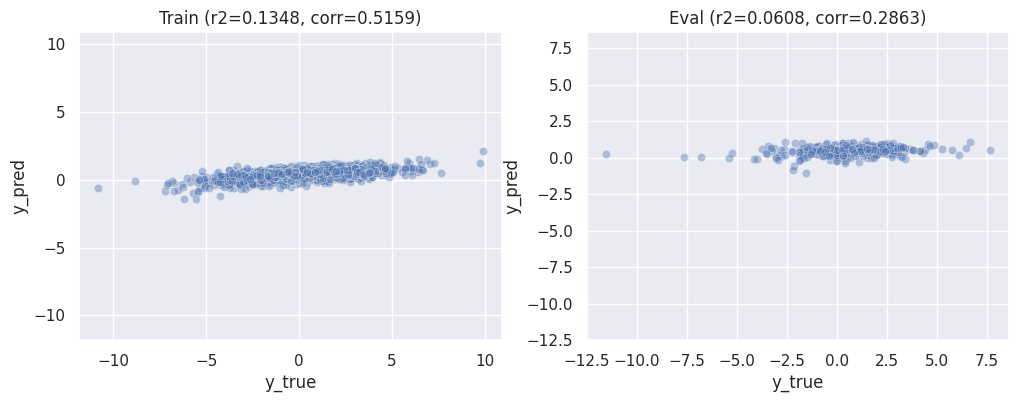

In [30]:
x_sbp, y_sbp = get_xy("SBP")
sbp_sweep = wandb.Api().sweep("olink_change_sbp/r59s1owo")
best_run = sbp_sweep.best_run(order="r2")
model_sbp = eval_xgb(x_sbp, y_sbp, best_run.config)

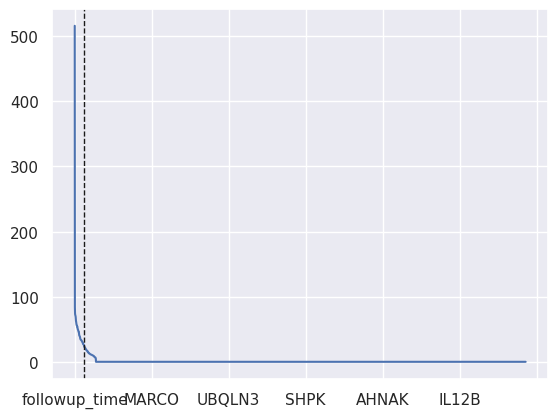

In [31]:
explainer = shap.TreeExplainer(model_sbp)
shap_values_sbp = explainer(x_sbp)
imps = shap_to_importance(shap_values_sbp, x_sbp.columns)
sbp_elbow = get_elbow_point(imps)
sbp_important_feats = imps[:sbp_elbow]

In [32]:
sbp_important_feats.index.values, f"Number of important feats: {len(sbp_important_feats)}"

(array(['followup_time', 'F10', 'SUSD4', 'NPTXR', 'TNFRSF6B', 'NTproBNP',
        'SERPINA4', 'PM20D1', 'FAM171B', 'GSTM4', 'BPIFB1', 'IFNL1',
        'CHRDL1', 'DCTN2', 'NINJ1', 'GADD45B', 'MUC2', 'FOLR1', 'DFFA',
        'RNF41', 'CLPS', 'PTPRB', 'EXOSC10', 'CTSS', 'FCRL2', 'TMPRSS15',
        'PROK1', 'CTRB1', 'ITGB6', 'IGDCC3', 'LAMP1', 'REN', 'CDHR1',
        'NID1', 'SH2B3', 'MATN3', 'LDLR', 'HS6ST2', 'MAMDC2', 'TNFRSF13C',
        'PTGDS', 'SAT1', 'FRMD7', 'TFF2', 'CAPG', 'APOH', 'PTH1R', 'SCN2B',
        'KRT18', 'CLEC5A', 'FABP2', 'CTSV', 'CUZD1', 'KRT8', 'FCRL6',
        'PRRT3', 'MAPK9', 'SSC5D', 'CD93', 'SLC44A4', 'APOM', 'CNTF',
        'COL24A1'], dtype=object),
 'Number of important feats: 63')

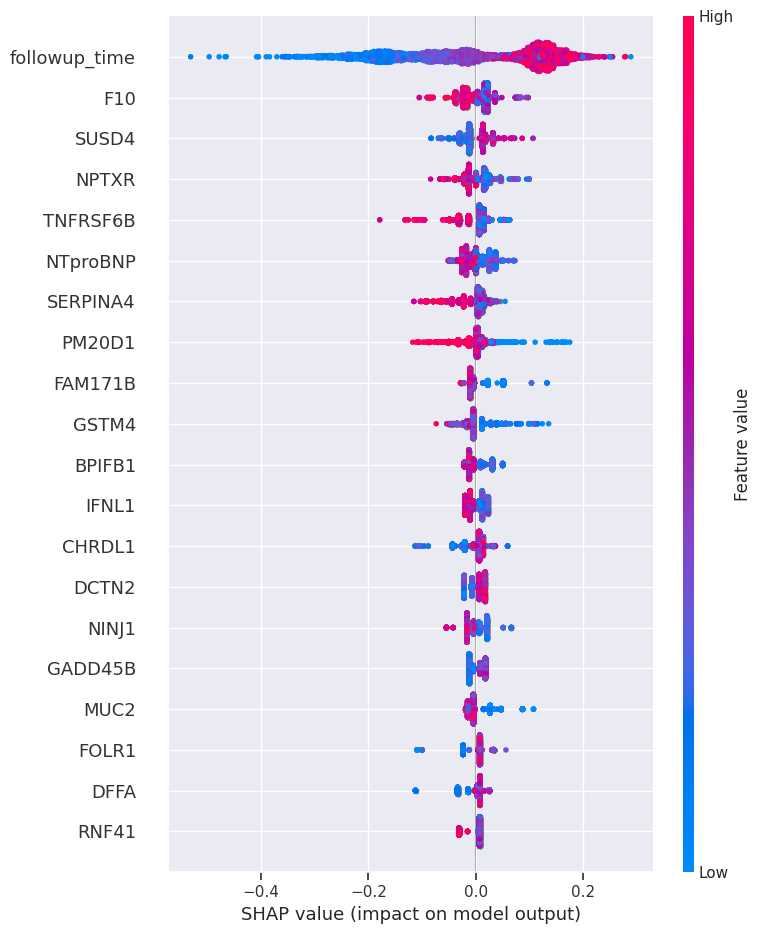

In [33]:
shap.summary_plot(shap_values_sbp, x_sbp.to_pandas(), max_display=min(len(sbp_important_feats), 20))

## DBP

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:1.09106
[10]	validation_0-rmse:1.07704
[20]	validation_0-rmse:1.06760
[30]	validation_0-rmse:1.05797
[40]	validation_0-rmse:1.05062
[50]	validation_0-rmse:1.04698
[60]	validation_0-rmse:1.04381
[70]	validation_0-rmse:1.04154
[80]	validation_0-rmse:1.03911
[90]	validation_0-rmse:1.03627
[100]	validation_0-rmse:1.03451
[110]	validation_0-rmse:1.03192
[120]	validation_0-rmse:1.03076
[130]	validation_0-rmse:1.02953
[140]	validation_0-rmse:1.02858
[150]	validation_0-rmse:1.02805
[160]	validation_0-rmse:1.02610
[170]	validation_0-rmse:1.02574
[179]	validation_0-rmse:1.02740


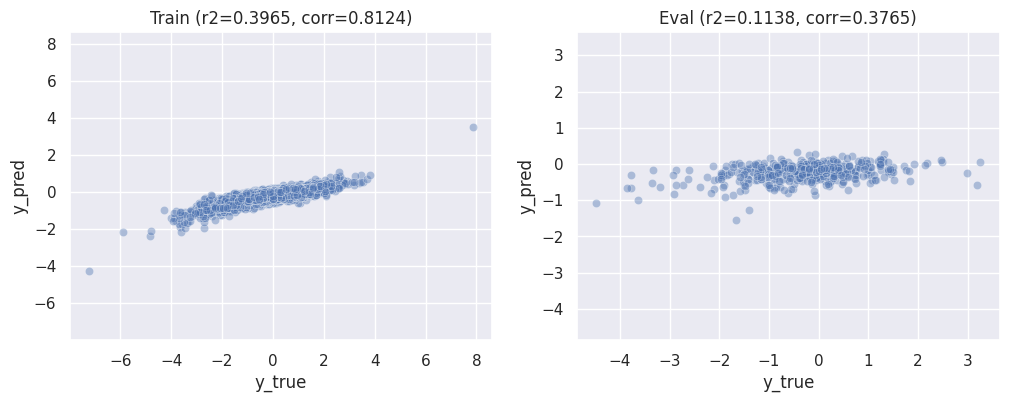

In [24]:
x_dbp, y_dbp = get_xy("DBP")
sbp_sweep = wandb.Api().sweep("olink_change_dbp/p2zfmuhv")
best_run = sbp_sweep.best_run(order="r2")
model_dbp = eval_xgb(x_dbp, y_dbp, best_run.config)

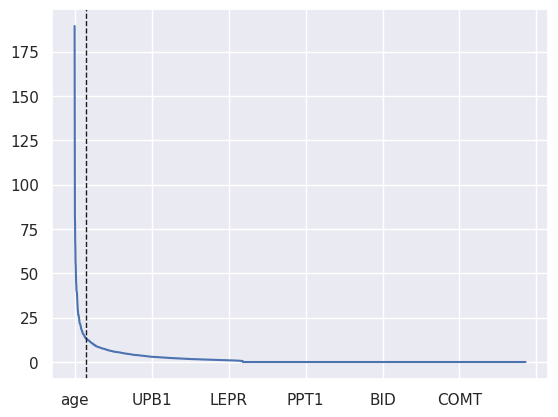

In [25]:
explainer = shap.TreeExplainer(model_dbp)
shap_values_dbp = explainer(x_dbp)
imps = shap_to_importance(shap_values_dbp, x_dbp.columns)
dbp_elbow = get_elbow_point(imps)
dbp_important_feats = imps[:dbp_elbow]

In [26]:
dbp_important_feats.index.values, f"Number of important feats: {len(dbp_important_feats)}"

(array(['age', 'followup_time', 'GIP', 'IGSF9', 'ACTA2', 'TSHB', 'AGER',
        'GSTA3', 'HAVCR1', 'KLK6', 'ADCYAP1R1', 'CPA2', 'PLAT', 'RIDA',
        'SCLY', 'GCG', 'MCAM', 'MATN2', 'ZP4', 'MASP1', 'REN', 'F9',
        'LDLR', 'RBP5', 'FABP9', 'F7', 'CFB', 'LTO1', 'CDC37', 'RGMB',
        'GGH', 'ADGRG2', 'MSLNL', 'FTCD', 'CCL18', 'IL11', 'CA14', 'IL13',
        'ATP6AP2', 'CPM', 'TNFRSF11B', 'SUSD4', 'FASLG', 'TCTN3',
        'CEACAM8', 'CCDC50', 'SERPINB9', 'GALNT10', 'NADK', 'PRG3',
        'FGF21', 'BPIFB1', 'RLN2', 'ENPP7', 'HJV', 'PCBD1', 'BLMH', 'CDH4',
        'ANXA5', 'TDP1', 'SCIN', 'ANGPT2', 'SERPING1', 'FCGR2A', 'LIF',
        'TMPRSS15', 'KRT17', 'KCTD5', 'CES1', 'CFI', 'ANGPTL1'],
       dtype=object),
 'Number of important feats: 71')

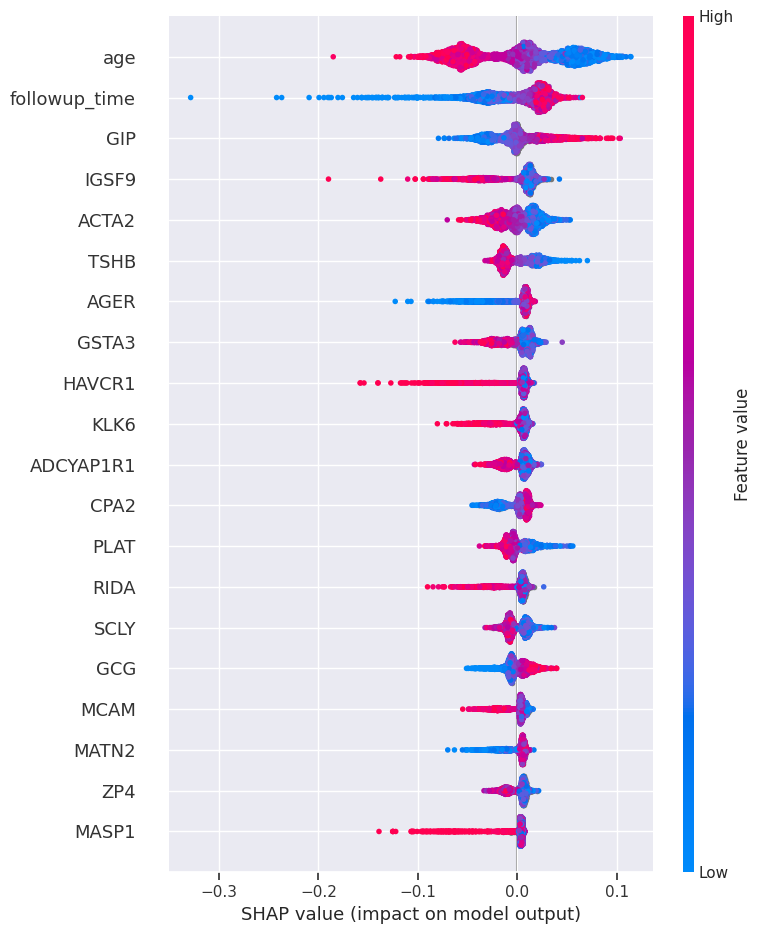

In [27]:
shap.summary_plot(shap_values_dbp, x_dbp.to_pandas(), max_display=min(len(dbp_important_feats), 20))

## ASI

## Wandb sweep

In [28]:
def wandb_eval_xgb(config, x, y, seed=42):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    estimator = setup_xgb(config, seed)
    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


target = "SBP"
project_name = f"olink_change_{target.lower()}"
x, y = get_xy(target)
print(x.shape)
objective = partial(wandb_eval_xgb, x=x, y=y)


def main():
    wandb.init(project=project_name)
    score = max(objective(wandb.config), -10)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
    },
}

sweep_id = wandb.sweep(sweep_configurations, project=project_name)
sweep_id

(4363, 2930)
Create sweep with ID: r59s1owo
Sweep URL: https://wandb.ai/ipol/olink_change_sbp/sweeps/r59s1owo


'r59s1owo'

In [29]:
wandb.teardown()
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: 3m1833g6 with config:
wandb: 	colsample_bytree: 0.846541637197357
wandb: 	gamma: 4.987673384454211
wandb: 	learning_rate: 0.0015458550594844732
wandb: 	max_depth: 9
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 97
wandb: 	reg_alpha: 2.570522692758612
wandb: 	reg_lambda: 9.898848627959024e-05
wandb: 	subsample: 0.7205264939406164
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.00526


wandb: Agent Starting Run: qs7x04hz with config:
wandb: 	colsample_bytree: 0.909358714291791
wandb: 	gamma: 8.064850557683
wandb: 	learning_rate: 0.0032456502539687394
wandb: 	max_depth: 5
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 238
wandb: 	reg_alpha: 2.423532940594705
wandb: 	reg_lambda: 2.784626375006262
wandb: 	subsample: 0.5189018911960065
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.01881


wandb: Agent Starting Run: zfs1s1vm with config:
wandb: 	colsample_bytree: 0.928491848744634
wandb: 	gamma: 6.772665152937366
wandb: 	learning_rate: 0.0075170259956825886
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 472
wandb: 	reg_alpha: 5.503670932864763e-05
wandb: 	reg_lambda: 0.0002693229603717547
wandb: 	subsample: 0.7870817722903208
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03336


wandb: Agent Starting Run: gzm3vtwr with config:
wandb: 	colsample_bytree: 0.8483300718967284
wandb: 	gamma: 6.704482814442667
wandb: 	learning_rate: 0.0045308564500390475
wandb: 	max_depth: 1
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 371
wandb: 	reg_alpha: 0.0002688091067669741
wandb: 	reg_lambda: 0.00032302141885738876
wandb: 	subsample: 0.771336144035313
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02496


wandb: Agent Starting Run: 1wj98iyr with config:
wandb: 	colsample_bytree: 0.9518140502902672
wandb: 	gamma: 4.292498618832806
wandb: 	learning_rate: 0.004890654054086681
wandb: 	max_depth: 3
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 500
wandb: 	reg_alpha: 8.552985634907611e-05
wandb: 	reg_lambda: 0.0001026022988870202
wandb: 	subsample: 0.792642220970746
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02944


wandb: Agent Starting Run: w0tkgu6a with config:
wandb: 	colsample_bytree: 0.9155398815674544
wandb: 	gamma: 7.951634099849104
wandb: 	learning_rate: 0.019540778160380096
wandb: 	max_depth: 5
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 0.0006503950559318924
wandb: 	reg_lambda: 0.0023782930379521385
wandb: 	subsample: 0.9598727612980285
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02759


wandb: Agent Starting Run: 3rh5tizm with config:
wandb: 	colsample_bytree: 0.9687380209386164
wandb: 	gamma: 3.728798467670803
wandb: 	learning_rate: 0.023307568257602915
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 499
wandb: 	reg_alpha: 0.00010246757560707468
wandb: 	reg_lambda: 1.845969890265914e-05
wandb: 	subsample: 0.6412226209730207
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03673


wandb: Agent Starting Run: yzdn03v5 with config:
wandb: 	colsample_bytree: 0.9693921829364124
wandb: 	gamma: 1.542115780383808
wandb: 	learning_rate: 0.09108074138377488
wandb: 	max_depth: 3
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 497
wandb: 	reg_alpha: 2.257092495049319e-05
wandb: 	reg_lambda: 0.03615577707227567
wandb: 	subsample: 0.54697595559413
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.06078


wandb: Agent Starting Run: ov3o16xh with config:
wandb: 	colsample_bytree: 0.8681337339897532
wandb: 	gamma: 3.8443291863145457
wandb: 	learning_rate: 0.09227145503660568
wandb: 	max_depth: 6
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 397
wandb: 	reg_alpha: 3.4069290967537765e-05
wandb: 	reg_lambda: 39.34372695967041
wandb: 	subsample: 0.6265031291372205
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.01832


wandb: Agent Starting Run: x0wvaz4n with config:
wandb: 	colsample_bytree: 0.9434180181769992
wandb: 	gamma: 1.1854650761075036
wandb: 	learning_rate: 0.022560900109904
wandb: 	max_depth: 4
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 457
wandb: 	reg_alpha: 0.02056584695604706
wandb: 	reg_lambda: 0.012038631509006517
wandb: 	subsample: 0.6417982210837421
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0306


wandb: Agent Starting Run: 7ii3mhhg with config:
wandb: 	colsample_bytree: 0.7950404616108493
wandb: 	gamma: 1.9415542494512117
wandb: 	learning_rate: 0.02820529498613421
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 435
wandb: 	reg_alpha: 0.0001953393735275286
wandb: 	reg_lambda: 0.001323994575785112
wandb: 	subsample: 0.5127511777642861
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03172


wandb: Agent Starting Run: hfcxc8si with config:
wandb: 	colsample_bytree: 0.8347710129476998
wandb: 	gamma: 0.4766807236819792
wandb: 	learning_rate: 0.03657398549530922
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 374
wandb: 	reg_alpha: 0.0003835004193878678
wandb: 	reg_lambda: 0.005917986639161538
wandb: 	subsample: 0.5525668866943297
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04201


wandb: Agent Starting Run: uojdq0x4 with config:
wandb: 	colsample_bytree: 0.9558753648583902
wandb: 	gamma: 4.036772090130901
wandb: 	learning_rate: 0.08926677584750746
wandb: 	max_depth: 1
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 1.2843042720761996e-05
wandb: 	reg_lambda: 7.464968620251101
wandb: 	subsample: 0.7746210043956364
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03434


wandb: Agent Starting Run: m3pm16vz with config:
wandb: 	colsample_bytree: 0.9661321174813228
wandb: 	gamma: 1.1222628951340952
wandb: 	learning_rate: 0.04112288712643062
wandb: 	max_depth: 2
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 408
wandb: 	reg_alpha: 4.405378300560474e-05
wandb: 	reg_lambda: 0.05841459566113347
wandb: 	subsample: 0.5418648197705362
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03592


wandb: Agent Starting Run: lkpdjyyu with config:
wandb: 	colsample_bytree: 0.78887364196124
wandb: 	gamma: 2.8221265716471864
wandb: 	learning_rate: 0.07059169198009196
wandb: 	max_depth: 7
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 0.000183740179817292
wandb: 	reg_lambda: 0.004720235067166301
wandb: 	subsample: 0.6791834528017959
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.01706


wandb: Agent Starting Run: v1dlfytn with config:
wandb: 	colsample_bytree: 0.767621048588714
wandb: 	gamma: 0.72064496190958
wandb: 	learning_rate: 0.02800368235488928
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 239
wandb: 	reg_alpha: 4.001083025731988e-05
wandb: 	reg_lambda: 0.000487467613023385
wandb: 	subsample: 0.5788236278337664
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02173


wandb: Agent Starting Run: ot40jzz6 with config:
wandb: 	colsample_bytree: 0.96892960966221
wandb: 	gamma: 1.8049163737446496
wandb: 	learning_rate: 0.05223035342798104
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 320
wandb: 	reg_alpha: 0.0001565435375190624
wandb: 	reg_lambda: 0.001400215568517785
wandb: 	subsample: 0.5481975233255912
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0254


wandb: Agent Starting Run: hqs5elrv with config:
wandb: 	colsample_bytree: 0.998461668536605
wandb: 	gamma: 2.003400017754444
wandb: 	learning_rate: 0.017767034716348863
wandb: 	max_depth: 4
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 436
wandb: 	reg_alpha: 1.9857713280392937e-05
wandb: 	reg_lambda: 0.013254067520847942
wandb: 	subsample: 0.5685004062889847
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02885


wandb: Agent Starting Run: d2qygyyq with config:
wandb: 	colsample_bytree: 0.9838805305399616
wandb: 	gamma: 3.9447893079206064
wandb: 	learning_rate: 0.03872724376058064
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 493
wandb: 	reg_alpha: 0.0011871144832332784
wandb: 	reg_lambda: 0.01273357097769462
wandb: 	subsample: 0.623165969661789
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02293


wandb: Agent Starting Run: updm1vhh with config:
wandb: 	colsample_bytree: 0.7943313534158725
wandb: 	gamma: 5.16663351437416
wandb: 	learning_rate: 0.024315207083072488
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 500
wandb: 	reg_alpha: 0.0001761359258543811
wandb: 	reg_lambda: 2.6967386153563015e-05
wandb: 	subsample: 0.6489670948689452
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03714


wandb: Agent Starting Run: akxapg1f with config:
wandb: 	colsample_bytree: 0.8572174626754551
wandb: 	gamma: 1.9860557990980057
wandb: 	learning_rate: 0.07742348966175114
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 489
wandb: 	reg_alpha: 0.0007576817562412943
wandb: 	reg_lambda: 2.9043734968619743
wandb: 	subsample: 0.5176277700696219
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04237


wandb: Agent Starting Run: oyb10x2a with config:
wandb: 	colsample_bytree: 0.8398042049202717
wandb: 	gamma: 2.2939044046836967
wandb: 	learning_rate: 0.03284461779368971
wandb: 	max_depth: 3
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 475
wandb: 	reg_alpha: 0.0007338464687799717
wandb: 	reg_lambda: 2.5964697773116154e-05
wandb: 	subsample: 0.6787117348659227
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03387


wandb: Agent Starting Run: vx0olt1c with config:
wandb: 	colsample_bytree: 0.8934971928100826
wandb: 	gamma: 0.38290715719415336
wandb: 	learning_rate: 0.0968240300924918
wandb: 	max_depth: 2
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 421
wandb: 	reg_alpha: 0.0004758914800427718
wandb: 	reg_lambda: 0.00840979857965458
wandb: 	subsample: 0.7304422759005624
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03824


wandb: Agent Starting Run: h2uutgwd with config:
wandb: 	colsample_bytree: 0.8146173745138123
wandb: 	gamma: 2.166149025251004
wandb: 	learning_rate: 0.07778790773612872
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 392
wandb: 	reg_alpha: 1.568089342149495e-05
wandb: 	reg_lambda: 1.1368979557454526
wandb: 	subsample: 0.5658890760324462
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.00942


wandb: Agent Starting Run: 4yjawpbq with config:
wandb: 	colsample_bytree: 0.8039714095041888
wandb: 	gamma: 1.7992970730684144
wandb: 	learning_rate: 0.08120390660227556
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 435
wandb: 	reg_alpha: 0.00026024814151994825
wandb: 	reg_lambda: 0.00012631859027005253
wandb: 	subsample: 0.6478565595850849
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03812


wandb: Agent Starting Run: 6k3cbser with config:
wandb: 	colsample_bytree: 0.8267180327768489
wandb: 	gamma: 0.4661370568919043
wandb: 	learning_rate: 0.08272601008667634
wandb: 	max_depth: 5
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 411
wandb: 	reg_alpha: 5.112484307781897e-05
wandb: 	reg_lambda: 0.004358526087150263
wandb: 	subsample: 0.6037805245407067
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.01014


wandb: Agent Starting Run: 5joskoqn with config:
wandb: 	colsample_bytree: 0.8772888973615605
wandb: 	gamma: 7.939694851879504
wandb: 	learning_rate: 0.004238581748688122
wandb: 	max_depth: 1
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 446
wandb: 	reg_alpha: 2.8903281565847783e-05
wandb: 	reg_lambda: 4.755045507933981e-05
wandb: 	subsample: 0.8898891958084127
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02779


wandb: Agent Starting Run: gucr4vlc with config:
wandb: 	colsample_bytree: 0.7370134318663089
wandb: 	gamma: 3.653984655159251
wandb: 	learning_rate: 0.0298658712895774
wandb: 	max_depth: 4
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 441
wandb: 	reg_alpha: 0.00023070513102307533
wandb: 	reg_lambda: 3.085300749018145e-05
wandb: 	subsample: 0.7067809429440954
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02215


wandb: Agent Starting Run: vm0xe9m8 with config:
wandb: 	colsample_bytree: 0.8189165825415301
wandb: 	gamma: 2.8044630740798326
wandb: 	learning_rate: 0.026841939048588163
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 428
wandb: 	reg_alpha: 0.001252063250949811
wandb: 	reg_lambda: 0.00015886931497817816
wandb: 	subsample: 0.6422771024198889
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03479


wandb: Agent Starting Run: pqi822sw with config:
wandb: 	colsample_bytree: 0.8526782481647798
wandb: 	gamma: 0.42625308123765415
wandb: 	learning_rate: 0.01053623988763839
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 414
wandb: 	reg_alpha: 0.00026485759497241716
wandb: 	reg_lambda: 0.1579823089529015
wandb: 	subsample: 0.6656872508097861
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03206


wandb: Agent Starting Run: xl3zzkly with config:
wandb: 	colsample_bytree: 0.8111781110026657
wandb: 	gamma: 2.251630057544899
wandb: 	learning_rate: 0.012375021885762652
wandb: 	max_depth: 3
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 394
wandb: 	reg_alpha: 0.0002347083826364419
wandb: 	reg_lambda: 4.908168400812075e-05
wandb: 	subsample: 0.5352233347885191
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02344


wandb: Agent Starting Run: aoh9d5g1 with config:
wandb: 	colsample_bytree: 0.8623028538330448
wandb: 	gamma: 0.6572195749225795
wandb: 	learning_rate: 0.06768075410382336
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 0.00037665859236122456
wandb: 	reg_lambda: 0.06299030304356977
wandb: 	subsample: 0.507994632097913
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03902


wandb: Agent Starting Run: mr44jsj9 with config:
wandb: 	colsample_bytree: 0.9150477996148167
wandb: 	gamma: 3.049202845008839
wandb: 	learning_rate: 0.04224625405613923
wandb: 	max_depth: 1
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 354
wandb: 	reg_alpha: 0.00010542007614530349
wandb: 	reg_lambda: 0.28695282322739857
wandb: 	subsample: 0.7480287046012589
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02765


wandb: Agent Starting Run: 0klujy0y with config:
wandb: 	colsample_bytree: 0.8257672705811641
wandb: 	gamma: 3.5809463698007016
wandb: 	learning_rate: 0.021026382115023175
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 415
wandb: 	reg_alpha: 0.00044600033122868304
wandb: 	reg_lambda: 4.039574238866968e-05
wandb: 	subsample: 0.6351206016883868
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02076


wandb: Agent Starting Run: bp1ny8dn with config:
wandb: 	colsample_bytree: 0.9000570110864912
wandb: 	gamma: 3.4848393079566584
wandb: 	learning_rate: 0.03668857037307475
wandb: 	max_depth: 2
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 444
wandb: 	reg_alpha: 0.00021256188805165695
wandb: 	reg_lambda: 0.14619834471411272
wandb: 	subsample: 0.5721552310796478
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03764


wandb: Agent Starting Run: 00isssrf with config:
wandb: 	colsample_bytree: 0.7381760888147461
wandb: 	gamma: 3.919448984016453
wandb: 	learning_rate: 0.04011925832116882
wandb: 	max_depth: 1
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 401
wandb: 	reg_alpha: 0.00021145456485136628
wandb: 	reg_lambda: 0.06412266561071776
wandb: 	subsample: 0.51823739320405
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02295


wandb: Agent Starting Run: v8qc1s7u with config:
wandb: 	colsample_bytree: 0.7614290861981752
wandb: 	gamma: 2.7124673489175555
wandb: 	learning_rate: 0.005971719882227232
wandb: 	max_depth: 1
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 482
wandb: 	reg_alpha: 0.0006896094634854627
wandb: 	reg_lambda: 0.003308565465650384
wandb: 	subsample: 0.594366242224424
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02264


wandb: Agent Starting Run: lflq4hqy with config:
wandb: 	colsample_bytree: 0.8873379852514007
wandb: 	gamma: 1.4985352302730204
wandb: 	learning_rate: 0.04431776872453157
wandb: 	max_depth: 1
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 424
wandb: 	reg_alpha: 0.0001918590048943709
wandb: 	reg_lambda: 0.0006839586467957062
wandb: 	subsample: 0.557978762040622
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03133


wandb: Agent Starting Run: 5g7f57mu with config:
wandb: 	colsample_bytree: 0.9928923019720444
wandb: 	gamma: 0.6258855728675916
wandb: 	learning_rate: 0.035359443929868166
wandb: 	max_depth: 2
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 382
wandb: 	reg_alpha: 0.11684273285372748
wandb: 	reg_lambda: 0.2754316636959858
wandb: 	subsample: 0.6730782969525271
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03258


wandb: Agent Starting Run: a9bc0aw4 with config:
wandb: 	colsample_bytree: 0.9500311072507368
wandb: 	gamma: 0.5985646249797472
wandb: 	learning_rate: 0.08693969571549692
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 392
wandb: 	reg_alpha: 0.00028677634453226343
wandb: 	reg_lambda: 0.019036012680547693
wandb: 	subsample: 0.5124512338584013
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0175


wandb: Agent Starting Run: 89auhent with config:
wandb: 	colsample_bytree: 0.8373777967170664
wandb: 	gamma: 1.964625292754314
wandb: 	learning_rate: 0.030080403013046396
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 465
wandb: 	reg_alpha: 1.5578024190482847e-05
wandb: 	reg_lambda: 0.521151313078893
wandb: 	subsample: 0.6134901591958262
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03022


wandb: Agent Starting Run: rlytgr2x with config:
wandb: 	colsample_bytree: 0.9500402535544072
wandb: 	gamma: 2.0937822848436216
wandb: 	learning_rate: 0.07677608418610057
wandb: 	max_depth: 2
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 413
wandb: 	reg_alpha: 0.0002801572656522454
wandb: 	reg_lambda: 0.030648710393907645
wandb: 	subsample: 0.553943072483453
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04952


wandb: Agent Starting Run: l45mh7oh with config:
wandb: 	colsample_bytree: 0.9957586295924216
wandb: 	gamma: 1.267425825108126
wandb: 	learning_rate: 0.045797221748471395
wandb: 	max_depth: 1
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 370
wandb: 	reg_alpha: 0.00012955352838649872
wandb: 	reg_lambda: 0.0008407289138138168
wandb: 	subsample: 0.5353789617513768
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02484


wandb: Agent Starting Run: awmu3dho with config:
wandb: 	colsample_bytree: 0.971523635036814
wandb: 	gamma: 1.85801240133587
wandb: 	learning_rate: 0.04812685532326919
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 395
wandb: 	reg_alpha: 0.0021183165425420103
wandb: 	reg_lambda: 0.0006306717852861498
wandb: 	subsample: 0.7527324256036554
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0236


wandb: Agent Starting Run: a6pbp5u3 with config:
wandb: 	colsample_bytree: 0.8660979734630794
wandb: 	gamma: 2.38956017510195
wandb: 	learning_rate: 0.06732345076605697
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 453
wandb: 	reg_alpha: 0.024775559953749745
wandb: 	reg_lambda: 0.004794684675445066
wandb: 	subsample: 0.5132197428664598
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03351


wandb: Agent Starting Run: ozctd440 with config:
wandb: 	colsample_bytree: 0.9261050571152944
wandb: 	gamma: 2.51461461490372
wandb: 	learning_rate: 0.05830504148473365
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 461
wandb: 	reg_alpha: 0.04889343616526214
wandb: 	reg_lambda: 44.356416317372414
wandb: 	subsample: 0.5154257404021043
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04199


wandb: Agent Starting Run: nig09ztm with config:
wandb: 	colsample_bytree: 0.8590666487733665
wandb: 	gamma: 2.729780921718713
wandb: 	learning_rate: 0.028413933559911213
wandb: 	max_depth: 2
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 443
wandb: 	reg_alpha: 0.015596900436865336
wandb: 	reg_lambda: 47.21503812936168
wandb: 	subsample: 0.5387057473627398
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03216


wandb: Agent Starting Run: sycndm4u with config:
wandb: 	colsample_bytree: 0.9042949262773798
wandb: 	gamma: 1.858534054953137
wandb: 	learning_rate: 0.09428285557100544
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 351
wandb: 	reg_alpha: 0.0007025924304930409
wandb: 	reg_lambda: 0.002965208142221389
wandb: 	subsample: 0.8101943135842888
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03763


wandb: Agent Starting Run: o6lphr32 with config:
wandb: 	colsample_bytree: 0.8697214798151671
wandb: 	gamma: 2.570569965233709
wandb: 	learning_rate: 0.0339078416394702
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 466
wandb: 	reg_alpha: 0.05030391415113153
wandb: 	reg_lambda: 0.001099122394667502
wandb: 	subsample: 0.6682734715336673
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03581


wandb: Agent Starting Run: fzmiolj1 with config:
wandb: 	colsample_bytree: 0.9128820440736974
wandb: 	gamma: 2.2026030462259394
wandb: 	learning_rate: 0.07667021223079014
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 469
wandb: 	reg_alpha: 0.00019327433457807605
wandb: 	reg_lambda: 10.135329971714356
wandb: 	subsample: 0.5853404953357586
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03607


wandb: Agent Starting Run: 6kqjhfln with config:
wandb: 	colsample_bytree: 0.9947161381887506
wandb: 	gamma: 1.1862023350945272
wandb: 	learning_rate: 0.033459995274173954
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 0.002212526241668638
wandb: 	reg_lambda: 0.005043944724754881
wandb: 	subsample: 0.6655517404453353
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03568


wandb: Agent Starting Run: 1gicjsu2 with config:
wandb: 	colsample_bytree: 0.8661592266029465
wandb: 	gamma: 4.290325822041018
wandb: 	learning_rate: 0.02442666254532386
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 476
wandb: 	reg_alpha: 0.4154572806188186
wandb: 	reg_lambda: 0.5521991927946783
wandb: 	subsample: 0.61125108085645
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03014


wandb: Agent Starting Run: vdimzm6e with config:
wandb: 	colsample_bytree: 0.9762911294610636
wandb: 	gamma: 1.1826566131779337
wandb: 	learning_rate: 0.03901600781115439
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 470
wandb: 	reg_alpha: 6.57322939591914e-05
wandb: 	reg_lambda: 11.342858477952188
wandb: 	subsample: 0.6174194707451255
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02876


wandb: Agent Starting Run: 4zl3w8em with config:
wandb: 	colsample_bytree: 0.8264465250739412
wandb: 	gamma: 3.592103417748272
wandb: 	learning_rate: 0.04798622181874736
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 369
wandb: 	reg_alpha: 0.006088235120318854
wandb: 	reg_lambda: 0.0026628716490557937
wandb: 	subsample: 0.7662342899380037
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02924


wandb: Agent Starting Run: tlly9bcp with config:
wandb: 	colsample_bytree: 0.7650681056074815
wandb: 	gamma: 0.3493284541728725
wandb: 	learning_rate: 0.08249164827572403
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 425
wandb: 	reg_alpha: 0.03583024499021264
wandb: 	reg_lambda: 20.646577260771945
wandb: 	subsample: 0.6837527947161344
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03562


wandb: Agent Starting Run: 4t7ja90x with config:
wandb: 	colsample_bytree: 0.9872295536263278
wandb: 	gamma: 2.6827534668642095
wandb: 	learning_rate: 0.03517812076996536
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 0.02555842560171261
wandb: 	reg_lambda: 0.34160986143646777
wandb: 	subsample: 0.725055573191823
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03199


wandb: Agent Starting Run: kbus54ip with config:
wandb: 	colsample_bytree: 0.8754815709936015
wandb: 	gamma: 0.34070088673745613
wandb: 	learning_rate: 0.010851683292618996
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 426
wandb: 	reg_alpha: 0.03908475423224021
wandb: 	reg_lambda: 6.530580389146672
wandb: 	subsample: 0.5280657590654994
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0237


wandb: Agent Starting Run: tq5h6c0c with config:
wandb: 	colsample_bytree: 0.9298408296099498
wandb: 	gamma: 1.0476184844648773
wandb: 	learning_rate: 0.07361534621188642
wandb: 	max_depth: 2
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 408
wandb: 	reg_alpha: 0.008691440442708734
wandb: 	reg_lambda: 0.06947014433923937
wandb: 	subsample: 0.5964560247035356
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03616


wandb: Agent Starting Run: symjnatv with config:
wandb: 	colsample_bytree: 0.8146053503010665
wandb: 	gamma: 2.4229007537455916
wandb: 	learning_rate: 0.07952887995209065
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 6.640155030455083
wandb: 	reg_lambda: 1.297168556431919
wandb: 	subsample: 0.5400505659721293
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.01198


wandb: Agent Starting Run: k2thafuw with config:
wandb: 	colsample_bytree: 0.992608214214896
wandb: 	gamma: 1.2442509201528815
wandb: 	learning_rate: 0.07401965220772028
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 343
wandb: 	reg_alpha: 9.360065193029008e-05
wandb: 	reg_lambda: 0.04537119250810539
wandb: 	subsample: 0.9603734010121076
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04952


wandb: Agent Starting Run: vh7xs43s with config:
wandb: 	colsample_bytree: 0.9702318100342228
wandb: 	gamma: 4.8581916615899825
wandb: 	learning_rate: 0.06046880205654951
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 343
wandb: 	reg_alpha: 0.009091676126258868
wandb: 	reg_lambda: 0.06270397818604448
wandb: 	subsample: 0.9899613539365142
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04497


wandb: Agent Starting Run: wijp0dl9 with config:
wandb: 	colsample_bytree: 0.8846260804957883
wandb: 	gamma: 6.031960338054672
wandb: 	learning_rate: 0.03278684866972738
wandb: 	max_depth: 4
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 442
wandb: 	reg_alpha: 0.0015859226697231585
wandb: 	reg_lambda: 0.25235717148178
wandb: 	subsample: 0.9737523520125132
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0344


wandb: Agent Starting Run: ot9lz5wy with config:
wandb: 	colsample_bytree: 0.9920498675861644
wandb: 	gamma: 2.906011161088519
wandb: 	learning_rate: 0.04067626879205359
wandb: 	max_depth: 5
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.000965060050472116
wandb: 	reg_lambda: 1.280876134992995
wandb: 	subsample: 0.8980267360740928
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04663


wandb: Agent Starting Run: suadzb3d with config:
wandb: 	colsample_bytree: 0.904166534336884
wandb: 	gamma: 2.368087573846074
wandb: 	learning_rate: 0.08005926012617892
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 333
wandb: 	reg_alpha: 0.0008075431947612355
wandb: 	reg_lambda: 0.4889390925712285
wandb: 	subsample: 0.8709139588853567
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.05208


wandb: Agent Starting Run: 78sh8vc2 with config:
wandb: 	colsample_bytree: 0.8446984058686995
wandb: 	gamma: 3.676015083709445
wandb: 	learning_rate: 0.05286539649009058
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 279
wandb: 	reg_alpha: 0.00045344360996821725
wandb: 	reg_lambda: 0.5081676285659287
wandb: 	subsample: 0.916822760191659
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03008


wandb: Agent Starting Run: zmbekh6j with config:
wandb: 	colsample_bytree: 0.961311470157977
wandb: 	gamma: 0.16052130804763975
wandb: 	learning_rate: 0.06434964829554392
wandb: 	max_depth: 2
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 431
wandb: 	reg_alpha: 0.000800510038982406
wandb: 	reg_lambda: 3.31840542031495
wandb: 	subsample: 0.9997478804359188
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04283


wandb: Agent Starting Run: jx6s3s8c with config:
wandb: 	colsample_bytree: 0.8443471641011768
wandb: 	gamma: 1.6557769923202414
wandb: 	learning_rate: 0.022521034388224045
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.00020635825421488012
wandb: 	reg_lambda: 0.2093566279296369
wandb: 	subsample: 0.9948770077785238
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04024


wandb: Agent Starting Run: go1kuuj9 with config:
wandb: 	colsample_bytree: 0.9394961873598024
wandb: 	gamma: 0.06483462852909128
wandb: 	learning_rate: 0.04075237299293704
wandb: 	max_depth: 1
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 260
wandb: 	reg_alpha: 0.01319861531497838
wandb: 	reg_lambda: 0.07815362833201152
wandb: 	subsample: 0.9890819091878228
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03353


wandb: Agent Starting Run: zl3o26gl with config:
wandb: 	colsample_bytree: 0.9744284338066432
wandb: 	gamma: 2.014247984753099
wandb: 	learning_rate: 0.055855527132803215
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 7.15650074577249e-05
wandb: 	reg_lambda: 0.16177107299364268
wandb: 	subsample: 0.9909781683260956
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04484


wandb: Agent Starting Run: w1y0ik6b with config:
wandb: 	colsample_bytree: 0.8704203331944521
wandb: 	gamma: 0.6670772208293607
wandb: 	learning_rate: 0.06093553181737739
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 427
wandb: 	reg_alpha: 0.00890055806395871
wandb: 	reg_lambda: 0.2015799477609437
wandb: 	subsample: 0.9359047516950084
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02584


wandb: Agent Starting Run: 0tirckgk with config:
wandb: 	colsample_bytree: 0.9765048260974124
wandb: 	gamma: 2.6226123918195645
wandb: 	learning_rate: 0.023206954414988587
wandb: 	max_depth: 3
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 235
wandb: 	reg_alpha: 0.014380053298503582
wandb: 	reg_lambda: 0.38742878295534067
wandb: 	subsample: 0.9314584671522764
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03063


wandb: Agent Starting Run: hkwb0xd0 with config:
wandb: 	colsample_bytree: 0.760773884501815
wandb: 	gamma: 1.1346954418787325
wandb: 	learning_rate: 0.05245278501497891
wandb: 	max_depth: 1
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 369
wandb: 	reg_alpha: 0.008224783561393455
wandb: 	reg_lambda: 0.891314419196768
wandb: 	subsample: 0.9339879382811718
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03839


wandb: Agent Starting Run: mdcwpt77 with config:
wandb: 	colsample_bytree: 0.8954034549127634
wandb: 	gamma: 6.210479081415459
wandb: 	learning_rate: 0.0965795069517978
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 321
wandb: 	reg_alpha: 0.03393937929617653
wandb: 	reg_lambda: 23.079426778395497
wandb: 	subsample: 0.974209379823991
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03834


wandb: Agent Starting Run: 8mliyeaa with config:
wandb: 	colsample_bytree: 0.9908734447191214
wandb: 	gamma: 1.8728243942457776
wandb: 	learning_rate: 0.05092426457640882
wandb: 	max_depth: 3
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 317
wandb: 	reg_alpha: 0.002312140420503909
wandb: 	reg_lambda: 0.05301392280688884
wandb: 	subsample: 0.8328092076947315
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04167


wandb: Agent Starting Run: pdcp9ea8 with config:
wandb: 	colsample_bytree: 0.938553287412908
wandb: 	gamma: 4.604557800052964
wandb: 	learning_rate: 0.08583678881630125
wandb: 	max_depth: 3
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 243
wandb: 	reg_alpha: 3.084657533578413e-05
wandb: 	reg_lambda: 0.06018434693791206
wandb: 	subsample: 0.9148041860675242
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03492


wandb: Agent Starting Run: rhed4rin with config:
wandb: 	colsample_bytree: 0.9024945239362208
wandb: 	gamma: 3.3612026097675773
wandb: 	learning_rate: 0.02162192815732163
wandb: 	max_depth: 3
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 393
wandb: 	reg_alpha: 0.00010668452769672036
wandb: 	reg_lambda: 0.1208986807663284
wandb: 	subsample: 0.9462734192668768
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04849


wandb: Agent Starting Run: 5y5dfrcb with config:
wandb: 	colsample_bytree: 0.8872388495182975
wandb: 	gamma: 4.054054476088186
wandb: 	learning_rate: 0.029405680787125483
wandb: 	max_depth: 2
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 383
wandb: 	reg_alpha: 3.6691783509932266e-05
wandb: 	reg_lambda: 0.23438628828247607
wandb: 	subsample: 0.8414313523561873
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03136


wandb: Agent Starting Run: zfah1e76 with config:
wandb: 	colsample_bytree: 0.9212154659572273
wandb: 	gamma: 0.6247287669610491
wandb: 	learning_rate: 0.06847103095084113
wandb: 	max_depth: 4
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 325
wandb: 	reg_alpha: 0.37887104742055233
wandb: 	reg_lambda: 2.7381826640050653
wandb: 	subsample: 0.9432141362518708
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03414


wandb: Agent Starting Run: bm05xv9i with config:
wandb: 	colsample_bytree: 0.9848595374150372
wandb: 	gamma: 3.2237617819598743
wandb: 	learning_rate: 0.09928075044463344
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 459
wandb: 	reg_alpha: 2.519953340751968e-05
wandb: 	reg_lambda: 0.0015547794534388302
wandb: 	subsample: 0.6116093004883136
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0296


wandb: Agent Starting Run: lyxbq5cv with config:
wandb: 	colsample_bytree: 0.9974803231595892
wandb: 	gamma: 0.87406269975699
wandb: 	learning_rate: 0.0883213654161078
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 424
wandb: 	reg_alpha: 0.001774403416790058
wandb: 	reg_lambda: 0.002195679401608098
wandb: 	subsample: 0.995142998083725
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03654


wandb: Agent Starting Run: gybsesa5 with config:
wandb: 	colsample_bytree: 0.9296106582716874
wandb: 	gamma: 1.2847081126376292
wandb: 	learning_rate: 0.029545854365500203
wandb: 	max_depth: 5
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 257
wandb: 	reg_alpha: 0.0004035907237299559
wandb: 	reg_lambda: 0.002401948049311056
wandb: 	subsample: 0.977629248089408
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02742


wandb: Agent Starting Run: c2zvehe4 with config:
wandb: 	colsample_bytree: 0.8426176624106219
wandb: 	gamma: 2.82065254922794
wandb: 	learning_rate: 0.06563809353710268
wandb: 	max_depth: 2
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 257
wandb: 	reg_alpha: 0.000941683642459243
wandb: 	reg_lambda: 0.2891005595916373
wandb: 	subsample: 0.961591013963122
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04596


wandb: Agent Starting Run: yxynrhyb with config:
wandb: 	colsample_bytree: 0.9940776316312784
wandb: 	gamma: 1.9603519329865415
wandb: 	learning_rate: 0.026781340778857982
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 445
wandb: 	reg_alpha: 0.000705810767904129
wandb: 	reg_lambda: 7.362323764286979
wandb: 	subsample: 0.991105846879472
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.028


wandb: Agent Starting Run: x32cy85u with config:
wandb: 	colsample_bytree: 0.8531290517929584
wandb: 	gamma: 0.8159605060012509
wandb: 	learning_rate: 0.035454979613802645
wandb: 	max_depth: 3
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 303
wandb: 	reg_alpha: 0.0010068480425459948
wandb: 	reg_lambda: 31.0977946349433
wandb: 	subsample: 0.9073004097943612
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03094


wandb: Agent Starting Run: d5mekmoz with config:
wandb: 	colsample_bytree: 0.9839900519247742
wandb: 	gamma: 0.3077386874751109
wandb: 	learning_rate: 0.07160971987729703
wandb: 	max_depth: 2
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 0.0002173257481445095
wandb: 	reg_lambda: 0.27963262551423007
wandb: 	subsample: 0.5878187053634175
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04041


wandb: Agent Starting Run: svf8avnk with config:
wandb: 	colsample_bytree: 0.8326849653879715
wandb: 	gamma: 2.347741626102162
wandb: 	learning_rate: 0.0039129029231679486
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 288
wandb: 	reg_alpha: 1.3779159147007646e-05
wandb: 	reg_lambda: 0.8062186718490452
wandb: 	subsample: 0.9937454774544024
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02869


wandb: Agent Starting Run: fxj5hpqh with config:
wandb: 	colsample_bytree: 0.9906148119484574
wandb: 	gamma: 4.6722622561279135
wandb: 	learning_rate: 0.04001028684155056
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 297
wandb: 	reg_alpha: 0.0005889405853698
wandb: 	reg_lambda: 10.596948694553609
wandb: 	subsample: 0.8211379240551315
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02069


wandb: Agent Starting Run: tuwh8dpw with config:
wandb: 	colsample_bytree: 0.9633368684830708
wandb: 	gamma: 5.919241871679136
wandb: 	learning_rate: 0.07528892254620116
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 391
wandb: 	reg_alpha: 0.009163270237056256
wandb: 	reg_lambda: 0.002646556087342174
wandb: 	subsample: 0.972946642827012
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.032


wandb: Agent Starting Run: u7vr90vu with config:
wandb: 	colsample_bytree: 0.8985478006583072
wandb: 	gamma: 2.486847289460772
wandb: 	learning_rate: 0.03109168676721502
wandb: 	max_depth: 1
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 0.00031648887216017706
wandb: 	reg_lambda: 0.10742579173433787
wandb: 	subsample: 0.8977438623467255
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03797


wandb: Agent Starting Run: 4s12pe09 with config:
wandb: 	colsample_bytree: 0.7990255816927119
wandb: 	gamma: 4.911462363436056
wandb: 	learning_rate: 0.07422460153067899
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 348
wandb: 	reg_alpha: 0.000930995587946639
wandb: 	reg_lambda: 0.13591488005504546
wandb: 	subsample: 0.9467212269906922
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03674


wandb: Agent Starting Run: hkc26zh6 with config:
wandb: 	colsample_bytree: 0.7216138455694873
wandb: 	gamma: 1.829523724692028
wandb: 	learning_rate: 0.03805114718004633
wandb: 	max_depth: 2
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 343
wandb: 	reg_alpha: 2.9671792699954317e-05
wandb: 	reg_lambda: 68.51771326281177
wandb: 	subsample: 0.939561356903579
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03845


wandb: Agent Starting Run: ejdaexkn with config:
wandb: 	colsample_bytree: 0.9615043616468116
wandb: 	gamma: 1.8342055446815544
wandb: 	learning_rate: 0.016350374272376865
wandb: 	max_depth: 2
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 283
wandb: 	reg_alpha: 0.00031924869099262787
wandb: 	reg_lambda: 0.035214123663436625
wandb: 	subsample: 0.9468819055115268
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03825


wandb: Agent Starting Run: ayr6ydd6 with config:
wandb: 	colsample_bytree: 0.9609707081379816
wandb: 	gamma: 0.15507417275223867
wandb: 	learning_rate: 0.043282519825153576
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 307
wandb: 	reg_alpha: 0.00012247085865522156
wandb: 	reg_lambda: 0.005164310626027039
wandb: 	subsample: 0.9219610203480896
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03084


wandb: Agent Starting Run: 8cunckdb with config:
wandb: 	colsample_bytree: 0.9282446142261443
wandb: 	gamma: 0.3350808125064464
wandb: 	learning_rate: 0.08369743022461383
wandb: 	max_depth: 5
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 402
wandb: 	reg_alpha: 0.00033088049713280056
wandb: 	reg_lambda: 0.29306868380754014
wandb: 	subsample: 0.9927676322669404
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.0522


wandb: Agent Starting Run: yj0znk44 with config:
wandb: 	colsample_bytree: 0.8903389035560141
wandb: 	gamma: 0.8627056176551628
wandb: 	learning_rate: 0.09250882580152202
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 431
wandb: 	reg_alpha: 0.0004302635406414141
wandb: 	reg_lambda: 0.043562586422733675
wandb: 	subsample: 0.831239643923386
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02264


wandb: Agent Starting Run: h0f9f2wv with config:
wandb: 	colsample_bytree: 0.8803099407807212
wandb: 	gamma: 1.177541649686188
wandb: 	learning_rate: 0.04348451256061913
wandb: 	max_depth: 1
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 442
wandb: 	reg_alpha: 5.356793639382704e-05
wandb: 	reg_lambda: 6.911772424569436
wandb: 	subsample: 0.9694306741750964
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03476


wandb: Agent Starting Run: uvisu0aq with config:
wandb: 	colsample_bytree: 0.7311290956268484
wandb: 	gamma: 4.06339293277691
wandb: 	learning_rate: 0.06880240773597149
wandb: 	max_depth: 2
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 86
wandb: 	reg_alpha: 0.032522436306098454
wandb: 	reg_lambda: 2.8606097846683145
wandb: 	subsample: 0.99306751786489
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04275


wandb: Agent Starting Run: 0xmbzc2e with config:
wandb: 	colsample_bytree: 0.7612429600569629
wandb: 	gamma: 1.953475069570082
wandb: 	learning_rate: 0.026152520521379376
wandb: 	max_depth: 1
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 209
wandb: 	reg_alpha: 0.0015764615016118394
wandb: 	reg_lambda: 0.09511145600653546
wandb: 	subsample: 0.8598018067465438
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03325


wandb: Agent Starting Run: 74z77v61 with config:
wandb: 	colsample_bytree: 0.9619516229634636
wandb: 	gamma: 1.9558419151255344
wandb: 	learning_rate: 0.046736658232007
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 391
wandb: 	reg_alpha: 2.368658677517986e-05
wandb: 	reg_lambda: 1.0585968867776978
wandb: 	subsample: 0.9919943507793854
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03164


wandb: Agent Starting Run: woffnqsg with config:
wandb: 	colsample_bytree: 0.8740977082162056
wandb: 	gamma: 4.5488363729276635
wandb: 	learning_rate: 0.057122807758623835
wandb: 	max_depth: 1
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 186
wandb: 	reg_alpha: 0.00013295264611092682
wandb: 	reg_lambda: 0.0055256688530647335
wandb: 	subsample: 0.9327834186131352
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03976


wandb: Agent Starting Run: aerrkboz with config:
wandb: 	colsample_bytree: 0.8896508716774723
wandb: 	gamma: 2.8598767278807893
wandb: 	learning_rate: 0.05386734196624562
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 361
wandb: 	reg_alpha: 0.004403671144355169
wandb: 	reg_lambda: 17.498136339842834
wandb: 	subsample: 0.8139940179857754
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03526


wandb: Agent Starting Run: k7gofb8a with config:
wandb: 	colsample_bytree: 0.946921345018076
wandb: 	gamma: 4.184205621027271
wandb: 	learning_rate: 0.09550239122448297
wandb: 	max_depth: 3
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 268
wandb: 	reg_alpha: 0.0200601457412703
wandb: 	reg_lambda: 0.270214217175721
wandb: 	subsample: 0.960589774145184
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03393


wandb: Agent Starting Run: 4muguw5b with config:
wandb: 	colsample_bytree: 0.7954832929229567
wandb: 	gamma: 2.403891708630762
wandb: 	learning_rate: 0.05472961233851686
wandb: 	max_depth: 2
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 356
wandb: 	reg_alpha: 8.168925621770119e-05
wandb: 	reg_lambda: 0.06246458204727647
wandb: 	subsample: 0.8994026509473351
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03396


wandb: Agent Starting Run: kvbnj593 with config:
wandb: 	colsample_bytree: 0.9280836902753822
wandb: 	gamma: 1.7739166263955153
wandb: 	learning_rate: 0.05570960046373803
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 373
wandb: 	reg_alpha: 3.319688041832407e-05
wandb: 	reg_lambda: 0.07755021487150561
wandb: 	subsample: 0.8638931133056441
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03595


wandb: Agent Starting Run: iuwnjmq7 with config:
wandb: 	colsample_bytree: 0.8276603345590742
wandb: 	gamma: 4.7867194281161565
wandb: 	learning_rate: 0.06926360644105219
wandb: 	max_depth: 2
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 291
wandb: 	reg_alpha: 0.00032714893361563183
wandb: 	reg_lambda: 27.072926951409915
wandb: 	subsample: 0.9615025426754168
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03943


wandb: Agent Starting Run: l9xmpa08 with config:
wandb: 	colsample_bytree: 0.9282021944165886
wandb: 	gamma: 2.6531172442511064
wandb: 	learning_rate: 0.09616306548174632
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 247
wandb: 	reg_alpha: 3.121880693219501e-05
wandb: 	reg_lambda: 0.0053131845871880684
wandb: 	subsample: 0.9133655798213304
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03858


wandb: Agent Starting Run: xaycgv0z with config:
wandb: 	colsample_bytree: 0.9080438771091228
wandb: 	gamma: 1.374932603507043
wandb: 	learning_rate: 0.0110054286392557
wandb: 	max_depth: 6
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 346
wandb: 	reg_alpha: 0.0009336940533160736
wandb: 	reg_lambda: 0.5510125635802366
wandb: 	subsample: 0.9592878789083464
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03301


wandb: Agent Starting Run: cn2l4a69 with config:
wandb: 	colsample_bytree: 0.9164493270920848
wandb: 	gamma: 4.970032994243503
wandb: 	learning_rate: 0.08053532623249843
wandb: 	max_depth: 3
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 408
wandb: 	reg_alpha: 6.590427554347835e-05
wandb: 	reg_lambda: 0.09186195971778922
wandb: 	subsample: 0.9743024205589932
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04156


wandb: Agent Starting Run: w6vk6old with config:
wandb: 	colsample_bytree: 0.978087222494327
wandb: 	gamma: 5.086089768942416
wandb: 	learning_rate: 0.054293049582066426
wandb: 	max_depth: 1
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 308
wandb: 	reg_alpha: 0.0019166045978881129
wandb: 	reg_lambda: 0.00621593084003921
wandb: 	subsample: 0.8974639785568921
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02932


wandb: Agent Starting Run: dje8onfe with config:
wandb: 	colsample_bytree: 0.8979603233100204
wandb: 	gamma: 3.132126508461577
wandb: 	learning_rate: 0.02648583263602046
wandb: 	max_depth: 2
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 316
wandb: 	reg_alpha: 0.00016651691962318307
wandb: 	reg_lambda: 0.014639118893906898
wandb: 	subsample: 0.9563957108288372
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03823


wandb: Agent Starting Run: bsvepq0i with config:
wandb: 	colsample_bytree: 0.7616557890518556
wandb: 	gamma: 0.6969865263391417
wandb: 	learning_rate: 0.06911414625490159
wandb: 	max_depth: 5
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 155
wandb: 	reg_alpha: 0.0012514156592104723
wandb: 	reg_lambda: 13.76207509793571
wandb: 	subsample: 0.9241772482255948
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02889


wandb: Agent Starting Run: 9u04ruxj with config:
wandb: 	colsample_bytree: 0.8210460633049135
wandb: 	gamma: 0.5738996234317773
wandb: 	learning_rate: 0.08354678701399973
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 342
wandb: 	reg_alpha: 0.004570904276809072
wandb: 	reg_lambda: 1.218942830004613
wandb: 	subsample: 0.9250124894413708
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03496


wandb: Agent Starting Run: 6fkh3mwb with config:
wandb: 	colsample_bytree: 0.9914957356291492
wandb: 	gamma: 1.3734815151586444
wandb: 	learning_rate: 0.023138866588703327
wandb: 	max_depth: 4
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.0069548957309343
wandb: 	reg_lambda: 0.15078209153692398
wandb: 	subsample: 0.9123496210260528
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02366


wandb: Agent Starting Run: o4j9k1in with config:
wandb: 	colsample_bytree: 0.6518832621228248
wandb: 	gamma: 4.484613154521691
wandb: 	learning_rate: 0.09820987108857458
wandb: 	max_depth: 1
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 169
wandb: 	reg_alpha: 0.2666795884752993
wandb: 	reg_lambda: 9.820175618152197
wandb: 	subsample: 0.9956165490857288
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03625


wandb: Agent Starting Run: 9srml0bq with config:
wandb: 	colsample_bytree: 0.8763920462158779
wandb: 	gamma: 1.9182577775173328
wandb: 	learning_rate: 0.06264391722619458
wandb: 	max_depth: 2
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 226
wandb: 	reg_alpha: 2.5467939841934497e-05
wandb: 	reg_lambda: 7.32303044127108
wandb: 	subsample: 0.8121996934284932
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03634


wandb: Agent Starting Run: 2rw15d3x with config:
wandb: 	colsample_bytree: 0.868885289745005
wandb: 	gamma: 3.949291901519174
wandb: 	learning_rate: 0.07433349867351956
wandb: 	max_depth: 4
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 215
wandb: 	reg_alpha: 0.04898522859791009
wandb: 	reg_lambda: 0.008796893447147899
wandb: 	subsample: 0.9802904991320284
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04471


wandb: Agent Starting Run: 792y97rr with config:
wandb: 	colsample_bytree: 0.8961310679980685
wandb: 	gamma: 1.558544778578952
wandb: 	learning_rate: 0.06097880243934953
wandb: 	max_depth: 2
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 413
wandb: 	reg_alpha: 0.031367190282225885
wandb: 	reg_lambda: 0.2225649459243857
wandb: 	subsample: 0.5632786083043428
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03719


wandb: Agent Starting Run: e3y39hqr with config:
wandb: 	colsample_bytree: 0.9432614759537332
wandb: 	gamma: 2.217238397103276
wandb: 	learning_rate: 0.05349735974733741
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 326
wandb: 	reg_alpha: 1.4491169020579909e-05
wandb: 	reg_lambda: 2.116492376419518
wandb: 	subsample: 0.9832087378553388
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03773


wandb: Agent Starting Run: 1amlv4pk with config:
wandb: 	colsample_bytree: 0.7805393532696725
wandb: 	gamma: 4.252702140286192
wandb: 	learning_rate: 0.040386016791651734
wandb: 	max_depth: 2
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 206
wandb: 	reg_alpha: 0.009395256376029748
wandb: 	reg_lambda: 0.004070574763460647
wandb: 	subsample: 0.978370744037928
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04052


wandb: Agent Starting Run: jsn6p8xa with config:
wandb: 	colsample_bytree: 0.8552603121150486
wandb: 	gamma: 3.300260008392364
wandb: 	learning_rate: 0.05841914538297097
wandb: 	max_depth: 2
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 374
wandb: 	reg_alpha: 0.5356625752525107
wandb: 	reg_lambda: 0.0144294715588839
wandb: 	subsample: 0.973160920562422
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04312


wandb: Agent Starting Run: e4wllrcl with config:
wandb: 	colsample_bytree: 0.9298734797475176
wandb: 	gamma: 0.2793954997907877
wandb: 	learning_rate: 0.013166737442014704
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 125
wandb: 	reg_alpha: 0.14433604532619446
wandb: 	reg_lambda: 5.131152657971614e-05
wandb: 	subsample: 0.9190799896969764
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02589


wandb: Agent Starting Run: bqprxcux with config:
wandb: 	colsample_bytree: 0.8308872469289799
wandb: 	gamma: 3.812271828688364
wandb: 	learning_rate: 0.03988387633276642
wandb: 	max_depth: 1
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 182
wandb: 	reg_alpha: 9.971320822170472e-05
wandb: 	reg_lambda: 0.23377764907409687
wandb: 	subsample: 0.8982244561563449
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03877


wandb: Agent Starting Run: cb8hy03u with config:
wandb: 	colsample_bytree: 0.9099408455268948
wandb: 	gamma: 3.457179304883502
wandb: 	learning_rate: 0.09972069217806316
wandb: 	max_depth: 2
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 3.91537002710815e-05
wandb: 	reg_lambda: 0.06640855586865867
wandb: 	subsample: 0.5181509994268636
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.04182


wandb: Agent Starting Run: nvyo0q13 with config:
wandb: 	colsample_bytree: 0.8858794365422306
wandb: 	gamma: 3.5305432359899735
wandb: 	learning_rate: 0.0847689977929315
wandb: 	max_depth: 4
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 416
wandb: 	reg_alpha: 0.00016770940584218694
wandb: 	reg_lambda: 1.597874612453121
wandb: 	subsample: 0.9385980075293596
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03285


wandb: Agent Starting Run: gei1kac2 with config:
wandb: 	colsample_bytree: 0.9771335993963716
wandb: 	gamma: 3.0335139541723377
wandb: 	learning_rate: 0.08982589075072898
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 493
wandb: 	reg_alpha: 2.8437779023679768e-05
wandb: 	reg_lambda: 0.012874955904533752
wandb: 	subsample: 0.7522557255986857
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.02971


wandb: Agent Starting Run: dx35lar4 with config:
wandb: 	colsample_bytree: 0.949010051720618
wandb: 	gamma: 3.08382063045194
wandb: 	learning_rate: 0.0703582072425916
wandb: 	max_depth: 1
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 113
wandb: 	reg_alpha: 0.005325298967868073
wandb: 	reg_lambda: 0.0003655096559204411
wandb: 	subsample: 0.9280476372813482
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03434


wandb: Agent Starting Run: 171zqtep with config:
wandb: 	colsample_bytree: 0.995330327720003
wandb: 	gamma: 4.762810943861862
wandb: 	learning_rate: 0.032870694838089326
wandb: 	max_depth: 4
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 411
wandb: 	reg_alpha: 0.01967278160845764
wandb: 	reg_lambda: 9.742540417294996e-05
wandb: 	subsample: 0.964306280471467
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.03783


wandb: Ctrl + C detected. Stopping sweep.
